In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [257]:
print(__doc__)

import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import entropy as calculate_entropy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Automatically created module for IPython interactive environment


In [ ]:
nlp = spacy.load("en_core_web_lg")

### utilities

In [3]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

def build_topic_word_distr(topics, word_topic_cos, words, topic_word_window_width, word_doc_frequency):
    topic_word_distr = pd.DataFrame(data=0.0, columns=topics, index=words)

    for topic in tqdm(range(len(topics))):
        word_topic_co = word_topic_cos[topic]
        word_word_co = pd.DataFrame(data=0.0, columns=word_topic_co[:topic_word_window_width].index, index=words)

        for index, (top_word, corelation) in enumerate(word_topic_co.items()):
            if index == topic_word_window_width:
                break

            word_word_frequency = corelation * word_doc_freqency[word_doc_freqency[top_word] > 0].sum(0)
            trust_factor = sigmoid((word_doc_freqency[top_word] > 0).sum(0))

            word_word_co[top_word] = (word_word_frequency * trust_factor) / word_doc_frequency
        topic_word_distr[topics[topic]] = word_word_co.max(1)
    return topic_word_distr

def infer_topic(label_classes, doc_vector, topic_word_distr):
    doc_topic_word_distr = topic_word_distr.copy()

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_vector
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [236]:
# total number of samples needed
datasize = 300
randomize = False

# retrieve dataset
categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']
label_classes = ['autos', 'religion', 'graphics', 'space']

assert len(label_classes) == len(categories)

docs = fetch_20newsgroups(subset='train', shuffle=randomize, remove=('headers', 'footers', 'quotes'), categories=categories)
docs, old_labels, classes = docs.data, docs.target, docs.target_names

### clean dataset

In [237]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

In [238]:
labels = []
clean_docs = []
max_document_length = None

# the new classes
sizes = [0] * len(label_classes)
assert len(label_classes) == len(sizes)

for index, doc in enumerate(docs):
    if len(clean_docs) == datasize*len(label_classes):
        break
        
    cd = clean_doc(doc)
    
    if len(cd) == 0 or cd.isspace() or (max_document_length is not None and len(cd) <= max_document_length):
        continue
        
    label_class = classes[old_labels[index]]
    label = categories.index(label_class)

    if sizes[label] < datasize:
        clean_docs.append(cd)
        labels.append(label)

        sizes[label] += 1

labels = np.array(labels)
print(clean_docs[0])

<apparently you re not a woman - my husband hates the auto door locks <feels safer in a car that locks easily  in addition to watching around <in a secluded spot, etc - have my keys ready to open the door so i m


In [239]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes: {label_classes} of size min:{min(sizes)}, max:{max(sizes)}")

there are 1200 docs and 4 classes: ['autos', 'religion', 'graphics', 'space'] of size min:300, max:300


### count words

In [305]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
train_docs, test_docs, train_labels, test_labels = train_test_split(clean_docs, labels, test_size=.33, random_state=42)

count_vectorizer.fit(train_docs)
vocabulary = count_vectorizer.get_feature_names()

print("word_count is", len(vocabulary))

word_count is 17523


### Prepare Datatset

In [306]:
# create doc count vectors
train_doc_vectors = count_vectorizer.transform(train_docs).toarray()
train_doc_vectors = (train_doc_vectors > 0).astype(float)
train_doc_vectors = normalize(train_doc_vectors, norm="l1", axis=1)

test_doc_vectors = count_vectorizer.transform(test_docs).toarray()
test_doc_vectors = (test_doc_vectors > 0).astype(float)
test_doc_vectors = normalize(test_doc_vectors, norm="l1", axis=1)

print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

804 train_docs, 396 test docs


In [307]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (804, 17524)


In [308]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1200 docs and 4 classes


In [309]:
document_word_frequency.head()

,00,000,0000,00000,0001,000100255pixel,00041032,0004136,0004246,0004422,...,zullen,zulu,zurbrin,zurvanism,zwaartepunten,zwak,zwakke,zware,zwarte,__labels__
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000388,0.000388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Prepare Binary Dataset

In [310]:
#reduce freq in doc to bin value of 1 or 0
word_doc_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_total_frequency = word_doc_freqency.sum(0)

### Word-Word Ratio

In [ ]:
word_word_co = pd.DataFrame(data=0.0, columns=vocabulary, index=vocabulary)

for i in tqdm(range(len(vocabulary))):
    w1 = vocabulary[i]
    token1 = nlp(w1)[0]
    
    for j, w2 in enumerate(vocabulary):
        token2 = nlp(w2)[0]
        
        similarity = token1.similarity(token2)
        word_word_co[w1][w2] = similarity
        word_word_co[w2][w1] = similarity
        
        if i == j:
            break    
print(f"word_word_co has shape {word_word_co.shape}")

In [ ]:
word_word_co.head()

### Topic and word corelation

In [311]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=vocabulary)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid((word_doc_freqency > 0).sum(0))
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_total_frequency).fillna(0)

topic_word_distr = topic_word_distr.T
entropy = np.nan_to_num(calculate_entropy(topic_word_distr, base=2))
topic_word_distr = (topic_word_distr * (np.e**(-entropy**2))).T
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (17523, 4)


In [312]:
topic_word_distr.head()

,autos,religion,graphics,space
00,0.014809,0.003754,0.153557,0.052406
000,0.081528,0.009158,0.020557,0.012874
0000,0.000000,0.000000,0.000000,0.880797
00000,0.000000,0.000000,0.000000,0.880797
0001,0.000000,0.731059,0.000000,0.000000


In [313]:
label_classes

['autos', 'religion', 'graphics', 'space']

In [314]:
label_class = 'graphics'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

3d           1.000000
vga          0.999999
animation    0.999998
formats      0.999994
tiff         0.999994
               ...   
third        0.000225
head         0.000217
radio        0.000213
days         0.000162
down         0.000160
Name: graphics, Length: 6721, dtype: float64

In [315]:
word="computer"
topic_word_distr.loc[word].sort_values(ascending=False)

graphics    0.190756
autos       0.049828
space       0.028531
religion    0.000000
Name: computer, dtype: float64

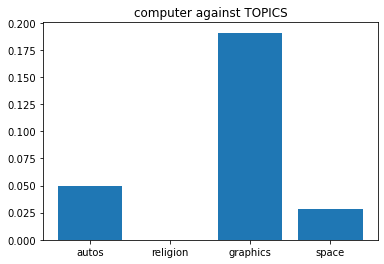

In [316]:
plt.title(f"{word} against TOPICS")
plt.bar(topic_word_distr.loc[word].index, topic_word_distr.loc[word])
plt.show()

### Evaluate Topic model with Train set

In [317]:
score = 0
misclassified_train = []
print("Evaluating Topic Model...")

for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if doc_topic != label_classes[train_labels[doc_index]]:
        misclassified_train.append(doc_index)
    
train_accuracy = score / (doc_index + 1)
print(f"==> train-accuracy is {train_accuracy*100:.2f}%, {len(misclassified_train)} misclassified\n")

Evaluating Topic Model...



==> train-accuracy is 99.88%, 1 misclassified



### Evaluating Topic Model with test set

In [318]:
score = 0
print("Evaluating Topic Model...")

misclassified_test = []
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    score += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if doc_topic != label_classes[test_labels[doc_index]]:
        misclassified_test.append(doc_index)
    

test_accuracy = score / (doc_index + 1)
print(f"==> test-accuracy is {test_accuracy*100:.2f}%, avg-accuarcy = {.5*(train_accuracy + test_accuracy)*100:.2f}%, {len(misclassified_test)} misclassified\n")

Evaluating Topic Model...



==> test-accuracy is 83.33%, avg-accuarcy = 91.60%, 66 misclassified



### Investigating Misclassification

In [321]:
training = False
tlabels = train_labels if training else test_labels
tdoc_vectors = train_doc_vectors if training else test_doc_vectors
misclassified = misclassified_train if training else misclassified_test

for doc_index in tqdm(misclassified):
    doc_vector = tdoc_vectors[doc_index]
    doc_topic_word_distr, doc_topic = infer_topic(label_classes, doc_vector, topic_word_distr)
    
    xv = doc_topic_word_distr.iloc[np.where(doc_topic_word_distr.sum(1) > 0)]
    print(xv.loc[xv.sum(1).sort_values(ascending=False).index])
    print(train_docs[doc_index])
    print(f"predicted_topic = {doc_topic}, actual_topic = {label_classes[tlabels[doc_index]]} \n")

              autos  religion  graphics     space
88         0.000000  0.000000  0.040036  0.000000
december   0.003561  0.000330  0.005328  0.000144
built      0.001269  0.000262  0.000619  0.003810
difficult  0.000534  0.000949  0.001299  0.000097
away       0.000849  0.000592  0.000101  0.000519
pretty     0.000476  0.000404  0.000208  0.000189
early      0.000351  0.000336  0.000138  0.000293
so         0.000348  0.000292  0.000277  0.000146
certainly  0.000196  0.000368  0.000201  0.000253
most       0.000214  0.000237  0.000191  0.000362
which      0.000192  0.000326  0.000269  0.000188
you        0.000265  0.000207  0.000257  0.000173
was        0.000285  0.000211  0.000188  0.000213
have       0.000279  0.000203  0.000223  0.000187
and        0.000232  0.000199  0.000266  0.000185
it         0.000253  0.000176  0.000236  0.000212
as         0.000217  0.000252  0.000175  0.000230
do         0.000189  0.000250  0.000239  0.000193
be         0.000198  0.000234  0.000190  0.000231


             autos  religion  graphics     space
lovely    0.000000  0.000000  0.036700  0.000000
dwell     0.000000  0.030461  0.000000  0.000000
worthy    0.000000  0.018639  0.000000  0.004202
praise    0.008797  0.006358  0.000000  0.000000
phil      0.000000  0.006536  0.000000  0.006987
pure      0.000000  0.001713  0.000895  0.001257
whatever  0.000372  0.001267  0.000786  0.000150
true      0.000425  0.001015  0.000325  0.000214
right     0.000959  0.000256  0.000254  0.000421
any       0.000373  0.000253  0.000658  0.000179
things    0.000234  0.000391  0.000158  0.000534
let       0.000464  0.000303  0.000239  0.000155
mind      0.000205  0.000466  0.000203  0.000246
finally   0.000157  0.000302  0.000376  0.000204
your      0.000402  0.000257  0.000199  0.000178
good      0.000343  0.000288  0.000274  0.000128
anything  0.000181  0.000253  0.000177  0.000346
on        0.000239  0.000155  0.000303  0.000204
these     0.000299  0.000238  0.000207  0.000153
there     0.000205  

[76 rows x 4 columns]
hi there ...   well, i have a 386/40 with svga 1mb.  oak chip 077  and i don t   have vesa tsr program for this card. i need it .     please... if anybody can help me, mail me at:    lulagos@araucaria.cec.uchile.cl
predicted_topic = religion, actual_topic = graphics 

                autos  religion  graphics     space
chip         0.013686  0.000000  0.012236  0.000000
phone        0.006985  0.000089  0.009381  0.000540
information  0.001163  0.000119  0.003387  0.001760
address      0.000048  0.001871  0.003130  0.001369
number       0.000411  0.000923  0.001576  0.000373
like         0.000674  0.000214  0.000529  0.000505
get          0.000677  0.000223  0.000532  0.000465
about        0.000635  0.000530  0.000363  0.000257
some         0.000319  0.000286  0.000575  0.000452
you          0.000416  0.000326  0.000404  0.000272
have         0.000439  0.000319  0.000350  0.000293
this         0.000303  0.000327  0.000421  0.000322
do           0.000297  0.000393  

                 autos  religion  graphics     space
intelligence  0.000000  0.000000  0.000000  0.011159
originally    0.000000  0.010573  0.000086  0.000197
humans        0.000000  0.009619  0.000000  0.000607
deeper        0.000000  0.010009  0.000000  0.000000
humanity      0.000000  0.010009  0.000000  0.000000
...                ...       ...       ...       ...
to            0.000056  0.000051  0.000057  0.000048
is            0.000048  0.000059  0.000053  0.000051
in            0.000059  0.000052  0.000050  0.000050
that          0.000056  0.000057  0.000049  0.000049
of            0.000054  0.000055  0.000052  0.000049

[88 rows x 4 columns]
see:    maureen stone and tony derose,     a geometric characterization of parametric cubic curves ,    acm tog, vol 8, no 3, july 1989, pp. 147-163. _______________________________________________________________________  ...ron capelli                 ibm corp.  dept. c13,  ms. p230    capelli@vnet.ibm.com        po box 950     914  435-

               autos  religion  graphics     space
minds       0.000000  0.016450  0.000000  0.000550
select      0.000000  0.000000  0.015734  0.000782
launch      0.000867  0.000000  0.000000  0.015459
nasa        0.000000  0.000000  0.001232  0.013895
caution     0.000000  0.013055  0.000000  0.000000
unexpected  0.000000  0.013055  0.000000  0.000000
nt          0.000000  0.013055  0.000000  0.000000
gotta       0.008094  0.000000  0.000000  0.002019
expected    0.000294  0.000199  0.000877  0.005548
warning     0.000429  0.000000  0.001161  0.005195
watching    0.005146  0.001078  0.000000  0.000480
saying      0.000152  0.004634  0.000397  0.000744
wondering   0.003272  0.000000  0.002558  0.000052
forget      0.001438  0.000287  0.000034  0.000675
verify      0.001185  0.000000  0.000768  0.000322
dumb        0.001316  0.000049  0.000256  0.000617
errors      0.000000  0.000580  0.001158  0.000425
maybe       0.000065  0.000157  0.000145  0.000304
say         0.000173  0.000275 

In [261]:
xv = train_doc_vectors[:, vocabulary.index("enough")]
xv[xv.argsort()[::-1]][:20]

array([0.07142857, 0.03947368, 0.03225806, 0.03125   , 0.02702703,
       0.02631579, 0.02325581, 0.02173913, 0.0212766 , 0.02040816,
       0.02      , 0.01587302, 0.01515152, 0.01492537, 0.01428571,
       0.01204819, 0.01176471, 0.0106383 , 0.01052632, 0.00877193])

In [256]:
for index in xv.argsort()[::-1][:20]:
    print(train_docs[index], '====>', label_classes[train_labels[index]])
    print()

usually....go enough places and you ll see stuff happen you didn t think did. ====> autos

depends. if you assume the existance of a working ssto like dc, on billion $$ would be enough to put about a quarter million pounds of stuff on the moon. if some of that mass went to send equipment to make lox for the transfer vehicle, you could send a lot more. either way, its a lot more than needed.  this prize isn t big enough to warrent developing a ssto, but it is enough to do it if the vehicle exists.    allen ====> space

where does the shadow come from?  there s nothing close enough to block sunlight from hitting them.  i wouldn t expect there to be anything block our view of them either.  what am i missing? ====> space

if raw materials where to cost enough that getting them from space would be cost effective then the entire world economy would colapse long before the space mines could be built.    allen ====> space

recently-manufactured locomotives have wheel-slip detection systems tha

In [116]:
xv.argsort()[::-1][20]

342